# Reverse optimization of school preferability parameters under MNL choice model

Max Kapur | <a href="https://www.maxkapur.com/">maxkapur.com</a>

As part of my research into admissions markets, I model student preferences using the multinomial logit choice function, which assigns each school a preferability parameter $\delta_c$. Then, given a set of admitted schools $C^\#$, students attend school $c$ with probability $$\frac{\exp \delta_c}{\sum_{d \in C^\#} \exp \delta_d}$$

When all schools use a common ranking over the students and admit students whose score exceeds a certain percentile $p_c$, then the demand for (percentage of students choosing to attend) school $c$ is given by the following expression:

$$D_c(p) = 
\sum_{d=c}^{|C|} 
\underbrace{\frac{\exp{\delta_c}}{ \sum_{i=1}^d \exp{\delta_i}}}_{\substack{\text{prob. of choosing  }\\ c\text{ from assortment}}} 
\overbrace{\left(p_{d+1} - p_{d}\right)}^{\substack{\text{prob. of having}\\ \text{assortment }C_{[d]}}} $$

Here we assume the schools are ordered by cutoff ($p_1 \leq \cdots \leq p_{|C|}$), and we take $p_{|C|+1} \equiv 1$. $C_{[d]}$ refers to the admitted school set consisting of the first $d$ schools.

The question asked here is, **given the demand for each school and its admissions cutoff, can we figure out the market's underlying preferability parameters?** This is not an easy question, because while schools publish their admissions rates and yield, these cannot be taken as a measure of overall preferability, because not all students apply to every school.

To start off with, we need some data to play with; since the assumption that all schools use a common ranking is itself unrealistic, I haven&rsquo;t  fretted too much about the details of how to derive the school cutoffs&mdash;Part 1 is just a proof of concept.

## Part 1: Data preprocessing in Python

Data source: https://www.kaggle.com/samsonqian/college-admissions

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's make the unrealistic assumption that each school admits every student whose SAT math score exceeds what the school has reported as its 25th percentile SAT math score.

That is, we are reinterpreting this column as the school's 0th percentile score and disregarding the others. A more accurate way of doing this would be to run principle component analysis over student data and use the first principle component as the common score. 

We assume the market is at equilibrium, meaning that schools have tuned their admissions parameters such that the total enrollment at each school matches the school's capacity exactly.

In [4]:
stats = pd.read_csv("admitstats_raw.csv")[['Name', 'Enrolled total', 'SAT Math 25th percentile score']]
stats.dropna(inplace=True)
stats['name'] = stats['Name']; del stats['Name']
stats['demand'] = stats['Enrolled total'].astype(int)
stats

,Enrolled total,SAT Math 25th percentile score,name,demand
0,1104.0,350.0,Alabama A & M University,1104
1,1773.0,520.0,University of Alabama at Birmingham,1773
3,651.0,510.0,University of Alabama in Huntsville,651
4,1479.0,370.0,Alabama State University,1479
5,6454.0,500.0,The University of Alabama,6454
...,...,...,...,...
1511,756.0,420.0,California State University-Channel Islands,756
1516,254.0,470.0,Ave Maria University,254
1525,562.0,490.0,University of South Florida-St Petersburg,562
1529,86.0,490.0,University of South Florida-Sarasota-Manatee,86


Using the table found [here](https://web.archive.org/web/20161128224433/https://collegereadiness.collegeboard.org/pdf/understanding-sat-scores-2016.pdf), convert the cutoff scores to percentiles with respect to the totality of SAT takers. 

In [5]:
SAT = pd.read_csv("SATpercentiles.csv", sep="\t")
percentile_dict = dict(zip(SAT['Score'], SAT['2016 Percentile']))
stats['cutoff'] = stats['SAT Math 25th percentile score'].apply(lambda x: percentile_dict[int(np.round(x, decimals=-1))]/100)
del stats['Enrolled total'], stats['SAT Math 25th percentile score']

In [42]:
# Sanity check
stats_sorted = stats.sort_values('cutoff')
stats_sorted

,name,demand,cutoff
1236,Lane College,405,0.00
160,Albertus Magnus College,132,0.01
1394,Virginia Union University,404,0.01
922,Livingstone College,395,0.01
663,Rust College,287,0.01
...,...,...,...
289,University of Chicago,1426,0.95
698,Washington University in St Louis,1610,0.95
100,Harvey Mudd College,217,0.95
551,Massachusetts Institute of Technology,1115,0.97


Get a sense for the shape of the cutoff distribution. 

<BarContainer object of 1182 artists>

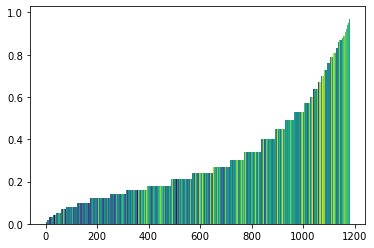

In [102]:
colspace = np.log(stats_sorted['demand'].to_numpy())
colspace -= colspace.min()
colspace /= colspace.max()

colors = plt.get_cmap('viridis')(colspace)

# Cutoffs in order, colored by demand
plt.bar(x=range(len(stats_sorted)), height=stats_sorted['cutoff'], width=1,
        color=colors)

In [5]:
stats.to_csv('admitstats.csv', index=False)